# Comprehensive Artificial Neural Network
This example is more comprehensive and realistic (less convenient) than the Iris dataset example and should illustrate some more practical issues being tackled. 

## Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Data

### Read Data

In [2]:
df = pd.read_csv('../../data/taxi_fares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


### Featurization Utils

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

In [3]:
# Haversine Formula (https://en.wikipedia.org/wiki/Haversine_formula) to calculate distance between two sets of lat and long coordinates.
def get_km_distance_from_coordinates(lat1: float, 
                                     lng1: float, 
                                     lat2: float, 
                                     lng2: float) -> float:    
    r = 6371  # Average radius of Earth in kilometers.

    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    
    delta_phi = np.radians(lat2-lat1)
    delta_lambda = np.radians(lng2-lng1)

    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

def featurize_distance_from_coordinates(df: pd.DataFrame, 
                                        lat1_col_name: str, 
                                        lng1_col_name: str, 
                                        lat2_col_name: str, 
                                        lng2_col_name: str) -> pd.DataFrame:
    __df__ = df.copy()
    __df__['dist_km'] = __df__.apply(lambda row: get_km_distance_from_coordinates(row[lat1_col_name], row[lng1_col_name], row[lat2_col_name], row[lng2_col_name]), axis=1)
    __df__.drop(columns=[lat1_col_name, lng1_col_name, lat2_col_name, lng2_col_name], inplace=True)
    
    return __df__

In [4]:
def featurize_time_from_column(df: pd.DataFrame, column_name: str, column_prefix: str='t_') -> pd.DataFrame:
        __df__ = df.copy()
        
        parsed_date_temporary_column = pd.to_datetime(__df__[column_name])
        __df__.drop(columns=[column_name], inplace=True)

        __df__[f'{column_prefix}year'] = parsed_date_temporary_column.dt.year
        __df__[f'{column_prefix}month'] = parsed_date_temporary_column.dt.month
        __df__[f'{column_prefix}day'] = parsed_date_temporary_column.dt.day
        __df__[f'{column_prefix}hour'] = parsed_date_temporary_column.dt.hour
        __df__[f'{column_prefix}minute'] = parsed_date_temporary_column.dt.minute
        __df__[f'{column_prefix}day_of_year'] = parsed_date_temporary_column.dt.dayofyear
        __df__[f'{column_prefix}day_of_week'] = parsed_date_temporary_column.dt.dayofweek
        __df__[f'{column_prefix}quarter'] = parsed_date_temporary_column.dt.quarter
        __df__[f'{column_prefix}am_or_pm'] = np.where(__df__[f'{column_prefix}hour'] > 12, 'pm', 'am') 

        return __df__

In [5]:
def featurized_categorical_data(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    __df__ = df.copy()
    sizes = list()

    # Pandas native categories.
    for column_name in columns:
        __df__[column_name] = __df__[column_name].astype('category')
        sizes.append(len(__df__[column_name].cat.categories))
        
    # These can be accessed as follows.
    # __df__[column_name].cat.categories
    # __df__[column_name].cat.codes
    
    return __df__, [(size, min(50, (size + 1) // 2)) for size in sizes]

In [6]:
def get_tensor_for_featurized_df(df: pd.DataFrame, label_column_name: str, categorical_column_names: list) -> torch.tensor:
    continuous_col_names = [continuous_col_name for continuous_col_name in df.columns if continuous_col_name not in categorical_column_names + [label_column_name]]
    continuous_data = df[continuous_col_names]
    categorical_data = np.stack([df[cat_col_name].cat.codes.values for cat_col_name in categorical_column_names], axis=1)
    x_cont = torch.tensor(continuous_data.values, dtype=torch.float)
    x_cat = torch.tensor(categorical_data, dtype=torch.int64)
    y = torch.tensor(df[label_column_name].values, dtype=torch.float).reshape(-1,1) # Reshape to retain a column instead of a row.
    
    return x_cont, x_cat, y

### Feature Engineering

In [7]:
label_column_name = 'fare_amount'
categorical_column_names = ['t_am_or_pm']

featurized_df = featurize_distance_from_coordinates(df, lat1_col_name='pickup_latitude', lng1_col_name='pickup_longitude', lat2_col_name='dropoff_latitude', lng2_col_name='dropoff_longitude')
featurized_df = featurize_time_from_column(featurized_df, column_name='pickup_datetime')
featurized_df, embedding_sizes = featurized_categorical_data(featurized_df, categorical_column_names)

featurized_df.head()

,fare_amount,fare_class,passenger_count,dist_km,t_year,t_month,t_day,t_hour,t_minute,t_day_of_year,t_day_of_week,t_quarter,t_am_or_pm
0,6.5,0,1,2.126312,2010,4,19,8,17,109,0,2,am
1,6.9,0,1,1.392307,2010,4,17,15,43,107,5,2,pm
2,10.1,1,2,3.326763,2010,4,17,11,23,107,5,2,am
3,8.9,0,1,1.864129,2010,4,11,21,25,101,6,2,pm
4,19.7,1,1,7.231321,2010,4,17,2,19,107,5,2,am


In [8]:
x_continuous, x_categorical, y = get_tensor_for_featurized_df(df=featurized_df, 
                                                              label_column_name=label_column_name, 
                                                              categorical_column_names=categorical_column_names)

print(x_continuous, x_categorical, y)

tensor([[  0.0000,   1.0000,   2.1263,  ..., 109.0000,   0.0000,   2.0000],
        [  0.0000,   1.0000,   1.3923,  ..., 107.0000,   5.0000,   2.0000],
        [  1.0000,   2.0000,   3.3268,  ..., 107.0000,   5.0000,   2.0000],
        ...,
        [  1.0000,   3.0000,   5.0525,  ..., 108.0000,   6.0000,   2.0000],
        [  0.0000,   1.0000,   1.2089,  ..., 103.0000,   1.0000,   2.0000],
        [  0.0000,   3.0000,   1.4274,  ..., 107.0000,   5.0000,   2.0000]]) tensor([[0],
        [1],
        [0],
        ...,
        [1],
        [0],
        [1]]) tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        ...,
        [12.5000],
        [ 4.9000],
        [ 5.3000]])


## Model

In [9]:
class TabularModel(nn.Module):
    def __init__(self, embedding_sizes: list, continuous_features_count: int, output_size: int, layers: list, dropout_probability: float=0.5):
        super().__init__()
        
        # Create embeddings for categorical columns.
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_sizes])
        
        # Dropout layer(s).
        self.emb_drop = nn.Dropout(dropout_probability)
        
        # Normalize continuous data.
        self.bn_cont = nn.BatchNorm1d(continuous_features_count)
        
        # Layers.
        layerlist = list()
        n_emb = sum([nf for ni, nf in embedding_sizes])
        n_in = n_emb + continuous_features_count
        
        for i in layers:
            layerlist.append(nn.Linear(in_features=n_in, out_features=i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(num_features=i))
            layerlist.append(nn.Dropout(p=dropout_probability))
            n_in = i
            
        layerlist.append(nn.Linear(in_features=layers[-1], out_features=output_size))
        
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self, x_categorical_features, x_continuous_features):
        # Categorical layers processing.
        embeddings = []
        
        for index, layer in enumerate(self.embeds):
            embeddings.append(layer(x_categorical_features[:, index]))
            
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        # Continuous layers processing.
        x_continuous_features = self.bn_cont(x_continuous_features)
        x = torch.cat([x, x_continuous_features], 1)
        x = self.layers(x)
        
        return x

## Training

In [10]:
torch.manual_seed(33)
model = TabularModel(embedding_sizes=embedding_sizes, continuous_features_count=x_continuous.shape[1], output_size=1, layers=[200,100], dropout_probability=0.4)
criterion = nn.MSELoss() # np.sqrt(MSE) --> RMSE. Also for multi-class problems, switch to nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Split train / test.
batch_size = featurized_df.shape[0] // 2
test_size = int(batch_size * 0.2)

In [12]:
cat_train = x_categorical[:batch_size-test_size]
cat_test = x_categorical[batch_size-test_size:batch_size]
con_train = x_continuous[:batch_size-test_size]
con_test = x_continuous[batch_size-test_size:batch_size]

In [13]:
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [14]:
import time

start_time = time.time()
epochs = 300
losses = list()

for i in range(epochs):
    i += 1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train))
    losses.append(loss)
    
    if i % 10 == 1:
        print(f'Epoch: {i}, Loss: {loss}')
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
duration = time.time() - start_time
print(f'Training took: {duration / 60} minutes')

Epoch: 1, Loss: 12.610206604003906
Epoch: 11, Loss: 11.215508460998535
Epoch: 21, Loss: 10.721590042114258
Epoch: 31, Loss: 10.441245079040527
Epoch: 41, Loss: 10.23091983795166
Epoch: 51, Loss: 10.05447006225586
Epoch: 61, Loss: 9.899311065673828
Epoch: 71, Loss: 9.722216606140137
Epoch: 81, Loss: 9.549696922302246
Epoch: 91, Loss: 9.355417251586914
Epoch: 101, Loss: 9.131110191345215
Epoch: 111, Loss: 8.85471248626709
Epoch: 121, Loss: 8.547958374023438
Epoch: 131, Loss: 8.192715644836426
Epoch: 141, Loss: 7.813425540924072
Epoch: 151, Loss: 7.385909080505371
Epoch: 161, Loss: 6.9427618980407715
Epoch: 171, Loss: 6.456679344177246
Epoch: 181, Loss: 5.9375104904174805
Epoch: 191, Loss: 5.424644947052002
Epoch: 201, Loss: 4.941239356994629
Epoch: 211, Loss: 4.474081516265869
Epoch: 221, Loss: 4.1078362464904785
Epoch: 231, Loss: 3.8091461658477783
Epoch: 241, Loss: 3.604757308959961
Epoch: 251, Loss: 3.5150394439697266
Epoch: 261, Loss: 3.4472832679748535
Epoch: 271, Loss: 3.4022037982

## Validation / Visualization

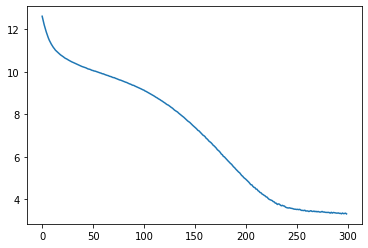

In [15]:
plt.plot(range(epochs), [float(l) for l in losses])

In [16]:
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
    
loss

tensor(3.3436)

In [17]:
for i in range(10):
    diff = np.abs(y_val[i].item() - y_test[i].item())
    print(f'Predicted: {y_val[i].item():8.2f}, Actual: {y_test[i].item():8.2f}, Delta: {diff:8.2f}')

Predicted:     2.49, Actual:     2.90, Delta:     0.41
Predicted:     7.40, Actual:     5.70, Delta:     1.70
Predicted:     6.88, Actual:     7.70, Delta:     0.82
Predicted:    13.35, Actual:    12.50, Delta:     0.85
Predicted:     6.31, Actual:     4.10, Delta:     2.21
Predicted:     3.50, Actual:     5.30, Delta:     1.80
Predicted:     3.92, Actual:     3.70, Delta:     0.22
Predicted:    21.64, Actual:    14.50, Delta:     7.14
Predicted:     3.71, Actual:     5.70, Delta:     1.99
Predicted:    11.94, Actual:    10.10, Delta:     1.84


## Save the Model

In [18]:
torch.save(model.state_dict(), '../../data/taxi_model.pt')

In [19]:
loaded_model = TabularModel(embedding_sizes=embedding_sizes, continuous_features_count=x_continuous.shape[1], output_size=1, layers=[200,100], dropout_probability=0.4)
loaded_model.load_state_dict(torch.load('../../data/taxi_model.pt'))

loaded_model.eval()

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

## Make Prediction(s)

In [20]:
# Singular prediction.
pickup_datetime = '2010-04-19 08:17:56 UTC'
fare_amount = -1
expected_fare_amount = 6.5
fare_class = 0
pickup_longitude = -73.992365
pickup_latitude = 40.730521
dropoff_longitude = -73.975499
dropoff_latitude = 40.744746
passenger_count = 1

# Create a DF from the data.
df_to_predict = pd.DataFrame({
    'pickup_datetime': [pickup_datetime],
    'fare_amount': [fare_amount],
    'fare_class': [fare_class],
    'pickup_longitude': [pickup_longitude],
    'pickup_latitude': [pickup_latitude],
    'dropoff_longitude': [dropoff_longitude],
    'dropoff_latitude': [dropoff_latitude],
    'passenger_count': [passenger_count]
})

featurized_df_to_predict = featurize_distance_from_coordinates(df_to_predict, lat1_col_name='pickup_latitude', lng1_col_name='pickup_longitude', lat2_col_name='dropoff_latitude', lng2_col_name='dropoff_longitude')
featurized_df_to_predict = featurize_time_from_column(featurized_df_to_predict, column_name='pickup_datetime')
featurized_df_to_predict, embedding_sizes = featurized_categorical_data(featurized_df_to_predict, categorical_column_names)
x_continuous_to_predict, x_categorical_to_predict, _ = get_tensor_for_featurized_df(df=featurized_df_to_predict, 
                                                              label_column_name=label_column_name, 
                                                              categorical_column_names=categorical_column_names)

loaded_model(x_categorical_to_predict, x_continuous_to_predict)[0].item()

7.165342807769775

In [21]:
# Multiple predictions at once.
original_df = df.copy()
predictions = model(x_categorical, x_continuous)
original_df['predicted_fare'] = pd.Series([pred.item() for pred in predictions])

original_df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,predicted_fare
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,7.511640
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,3.657721
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,13.568146
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,6.357605
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,20.403563


<AxesSubplot:xlabel='pickup_datetime'>

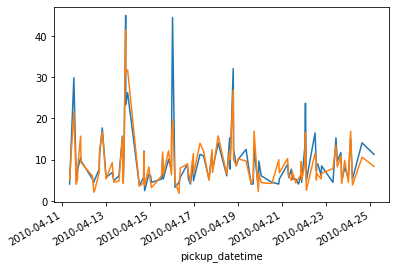

In [22]:
# Visuallize actual vs predicted values.
predicted_df_to_visualize = original_df.copy()
predicted_df_to_visualize['pickup_datetime'] = pd.to_datetime(predicted_df_to_visualize['pickup_datetime'])
predicted_df_to_visualize.set_index('pickup_datetime', inplace=True)

predicted_df_to_visualize.fare_amount[-100:].plot()
predicted_df_to_visualize.predicted_fare[-100:].plot()